# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from simfaas.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False, progress=True)
sim.print_trace_results()

100%|██████████| 1000000/1000000 [00:46<00:00, 21333.63it/s]
Cold Starts / total requests: 	 1183 / 900020
Cold Start Probability: 	 0.0013
Rejection / total requests: 	 0 / 900020
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6528.5989
Average Server Count:  		 7.6910
Average Running Count:  	 1.7971
Average Idle Count:  		 5.8940


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()
skip_init = sim.get_skip_init(skip_init_time=100)

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_index=skip_init)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_index=skip_init)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(7, 'u')        0.1135
(9, 'd')        0.0020
(12, 'u')       0.0006
(7, 'd')        0.2906
(9, 'u')        0.1177
(8, 'd')        0.0500
(6, 'd')        0.0514
(8, 'u')        0.3376
(11, 'd')       0.0000
(6, 'u')        0.0006
(5, 'u')        0.0000
(11, 'u')       0.0054
(10, 'u')       0.0305
(5, 'd')        0.0000
(10, 'd')       0.0000


,state,prob,sojourn_time
13,"(5, d)",0.000020,6.636937
10,"(5, u)",0.000003,2.753366
6,"(6, d)",0.051385,201.488057
9,"(6, u)",0.000574,143.552896
3,"(7, d)",0.290603,482.680581
0,"(7, u)",0.113474,443.213299
5,"(8, d)",0.050013,204.952165
7,"(8, u)",0.337625,559.564844
1,"(9, d)",0.002009,33.481638
4,"(9, u)",0.117734,482.468270


## Calculate Average Transition Times

In [4]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_index=skip_init)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
18,"(5, d)","(6, u)",3,6.636937,3,1.000000
0,"(5, u)","(6, u)",1,2.753366,1,1.000000
8,"(6, d)","(7, u)",252,201.433291,255,0.988235
17,"(6, d)","(5, d)",3,206.088416,255,0.011765
1,"(6, u)","(7, u)",4,143.552896,4,1.000000
6,"(7, d)","(8, u)",381,520.919647,602,0.632890
7,"(7, d)","(6, d)",221,416.757123,602,0.367110
13,"(7, u)","(6, d)",34,974.868074,256,0.132812
2,"(7, u)","(8, u)",222,361.788694,256,0.867188
5,"(8, d)","(7, d)",231,183.596110,244,0.946721


## Calculate Transition Time Histograms

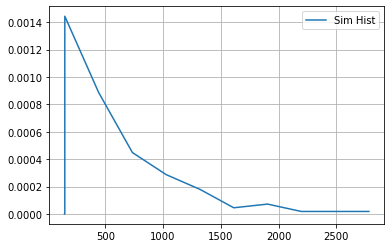

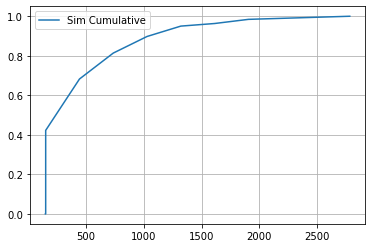

In [5]:
from simfaas.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Cold Start Probabily per State

In this section, we want to calculate the probability of a cold start occuring for a given state. This gives us a lot of insight about how to debug our performance model.

In [6]:
reqdf = sim.get_request_custom_states(hist_states=hist_states, skip_init_index=skip_init)
reqdf = reqdf.sort_values(by='state')
reqdf

,state,cold,warm,rej,total,p_cold
12,"(5, d)",3,22,0,25,0.120000
0,"(5, u)",1,4,0,5,0.200000
7,"(6, d)",252,45777,0,46029,0.005475
1,"(6, u)",4,518,0,522,0.007663
6,"(7, d)",381,261219,0,261600,0.001456
2,"(7, u)",222,101877,0,102099,0.002174
5,"(8, d)",13,45009,0,45022,0.000289
3,"(8, u)",231,303769,0,304000,0.000760
9,"(9, d)",1,1786,0,1787,0.000560
4,"(9, u)",59,105590,0,105649,0.000558


## Calculate Time Average of Server Count

Value           Prob
5               0.0000
6               0.0520
7               0.4041
8               0.3876
9               0.1197
10              0.0306
11              0.0054
12              0.0006


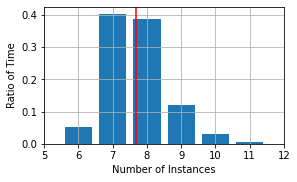

In [7]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.figure(figsize=(4,2.5))
plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')
plt.tight_layout()
plt.xlabel('Number of Instances')
plt.ylabel('Ratio of Time')
plt.xlim([5, 12])
plt.gcf().subplots_adjust(left=0.13, bottom=0.18)
plt.savefig('figs/03-example-instcount.pdf')

sim.print_time_average(unq_vals, val_times)

In [8]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,0.000023
1,6,0.051959
2,7,0.404077
3,8,0.387639
4,9,0.119743
5,10,0.030551
6,11,0.005409
7,12,0.000600


# Analyzing Transient Behaviour

In this section, we want to analyze the transient behaviour along with standard error of our estimate at different times.

In [9]:
max_time = 1e6

def run_sample_simulation():
    sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
                expiration_threshold=600, max_time=max_time)
    sim.generate_trace(debug_print=False, progress=True)
    sim.calculate_time_lengths()
    return sim

def get_inst_count_trace():
    sim = run_sample_simulation()
    skip_init = sim.get_skip_init(skip_init_time=0)
    values = sim.hist_server_count[skip_init:]
    times = sim.time_lengths[skip_init:]
    mult_sum = pd.Series(values * times).expanding(1).sum().to_numpy()
    times_sum = pd.Series(times).expanding(1).sum().to_numpy()
    return times_sum, mult_sum / times_sum # time, our estimated average for instance count at each time

all_t = []
all_inst_count_avg = []
trace_count = 10
for _ in range(trace_count):    
    t, inst_count_avg = get_inst_count_trace()
    all_t.append(t)
    all_inst_count_avg.append(inst_count_avg)

100%|██████████| 1000000/1000000 [00:47<00:00, 21178.02it/s]


(7.0, 8.5)

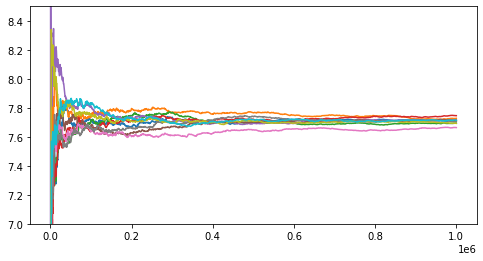

In [10]:
# plt.figure(figsize=(4,1.8))
plt.figure(figsize=(8,4))
for t, inst_count_avg in zip(all_t, all_inst_count_avg):
    plt.plot(t, inst_count_avg)
plt.ylim([7, 8.5])

We now need to have all measurement arrays have the same dimensionality to be able to calculate standard deviation of the measurement.

In [11]:
from tqdm import tqdm

getArrayIdxArr = lambda x, idx: np.array(x)[idx]
def sample_sim_history_idxs(hist_times, num_of_points=200):
    hist_idx = 0
    # go in 10 second steps
    hist_step = max_time / num_of_points
    idxs = [0]
    last_hist_time = 0
    while hist_idx < (len(hist_times) - 1):
        hist_idx += 1
        if hist_times[hist_idx] - last_hist_time < hist_step:
            continue

        last_hist_time = hist_times[hist_idx]
        idxs.append(hist_idx)
    return idxs

all_set_ts = []
all_sel_inst_counts = []
for t, inst_count_avg in tqdm(zip(all_t, all_inst_count_avg), total=trace_count):
    idxs = sample_sim_history_idxs(t)
    sel_t = t[idxs]
    sel_inst_counts = inst_count_avg[idxs]
    all_set_ts.append(sel_t)
    all_sel_inst_counts.append(sel_inst_counts)

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


In [12]:
inst_count_samples = np.stack(all_sel_inst_counts, axis=0)
inst_count_means = inst_count_samples.mean(axis=0)
inst_count_stds = inst_count_samples.std(axis=0)
t = all_set_ts[0] / 60 # convert to minutes
# slightly move time to the left for better plotting 
# with matplotlib (especially ticker)
t = t - t[0]

In [15]:
# show final 95% CI as the ratio of final estimation
inst_count_stds[-1] / inst_count_means[-1] * 100 * 2

0.5371089856394443

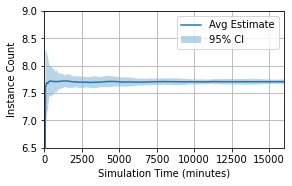

In [14]:
plt.figure(figsize=(4,2.5))
plt.plot(t, inst_count_means, label='Avg Estimate')
plt.fill_between(t, inst_count_means - inst_count_stds * 2, inst_count_means + inst_count_stds * 2, alpha=0.3, label='95% CI')
plt.grid(True)
plt.tight_layout()
plt.ylim([6.5, 9])
plt.xlim([0, 16000])
plt.xlabel('Simulation Time (minutes)')
plt.ylabel('Instance Count')
plt.legend()
plt.gcf().subplots_adjust(left=0.13, bottom=0.18)
plt.savefig('figs/02-inst-count-estimate-over-time.pdf')